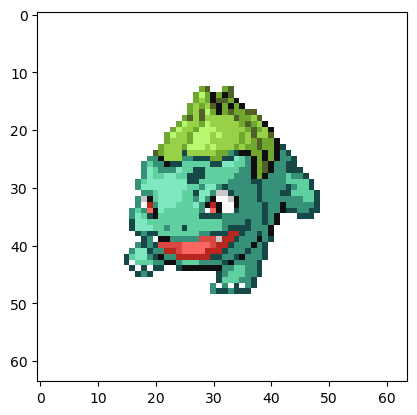

In [1]:
from PIL import Image
import torch
from torchvision import transforms
from torch import nn
import numpy as np

from matplotlib import pyplot as plt

torch.set_printoptions(sci_mode=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from load_dataset import load_dataset, plot_image
from tqdm import tqdm
from random import randint

pimages = load_dataset().to(device)
pimages.shape # [3, 386, 3, 64, 64]

plot_image(pimages[0, 0, :, :, :])

In [2]:
class PConv(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, bias=False, residual=False):
        super().__init__()
        self.residual = residual
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding='same', bias=bias),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
        )

    def forward(self, x):
        if self.residual:
            return self.conv(x) + x
        return self.conv(x)

class TConv(nn.Module):
    def __init__(self, in_c, out_c, bias=False):
        super().__init__()
        self.tconv = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1,
                               bias=bias),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
        )               
    
    def forward(self, x):
        return self.tconv(x)

In [3]:
#https://www.mdpi.com/2072-4292/11/9/1015/pdf
#@torch.compile
def ssim_loss(pred, target):
    mean_pred = torch.mean(pred, dim=(2, 3))
    mean_target = torch.mean(target, dim=(2, 3))

    var_pred = torch.var(pred, dim=(2, 3))
    var_target = torch.var(target, dim=(2, 3))

    cov = torch.mean(pred * target, dim=(2, 3)) - mean_pred * mean_target

    c1 = 0.01 ** 2
    c2 = 0.03 ** 2

    ssim = (2 * mean_pred * mean_target + c1) * (2 * cov + c2) 
    ssim /= (mean_pred ** 2 + mean_target ** 2 + c1) * (var_pred + var_target + c2)

    return (1 - ssim) / 2

In [4]:

class Colorizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Linear(64, 256)
        self.dmb = nn.Sequential(
            nn.Linear(256, 256),
            nn.Sigmoid(),
            nn.Linear(256, 3 * 8 * 8),
            nn.Sigmoid(),
        )
            

        self.layer = nn.TransformerEncoderLayer(d_model=256, nhead=8, batch_first=True)
        self.transformer = nn.TransformerEncoder(self.layer, num_layers=2)

    def forward(self, image_bw):
        # image_bw.shape = [bs, 64, 1, 8, 8]
        
        image_bw = image_bw.flatten(2, 4) #[bs, 64, 64]
        image_bw = self.emb(image_bw) #[bs, 64, 256]
        image_rgb = self.transformer(image_bw)
        image_rgb = self.dmb(image_rgb)
        
        image_rgb = image_rgb.unflatten(2, [3, 8, 8]) #[bs, 64, 3, 8, 8]

        return image_rgb * 2 - 1

  0%|          | 0/50001 [00:00<?, ?it/s]

torch.Size([1, 3, 48, 48])


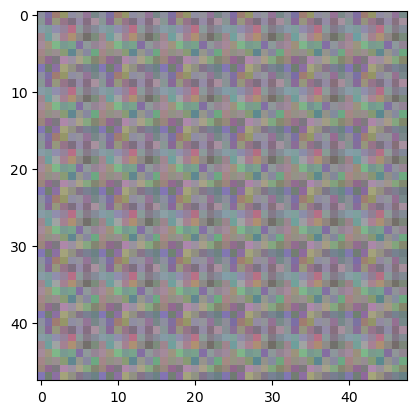

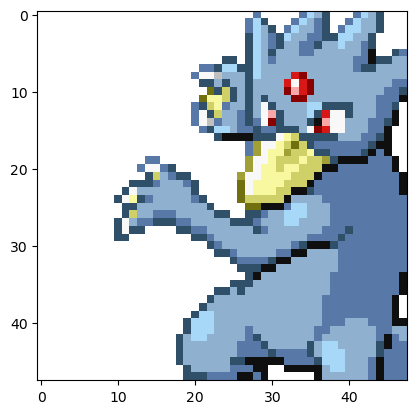

0.03933582:   2%|▏         | 999/50001 [00:11<08:57, 91.11it/s]

torch.Size([1, 3, 48, 48])


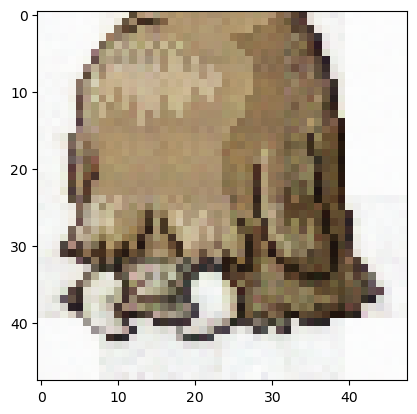

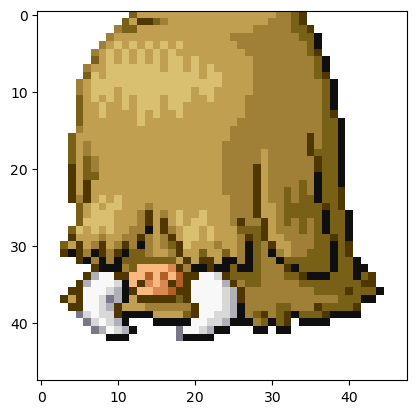

0.05381868:   4%|▍         | 1999/50001 [00:22<08:47, 90.93it/s]

torch.Size([1, 3, 48, 48])


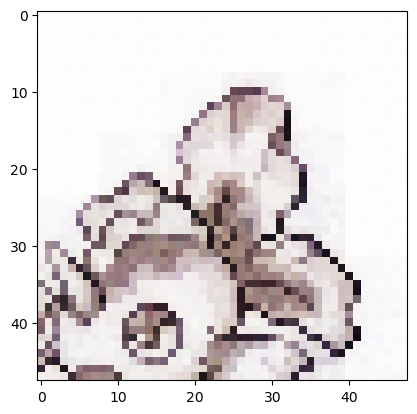

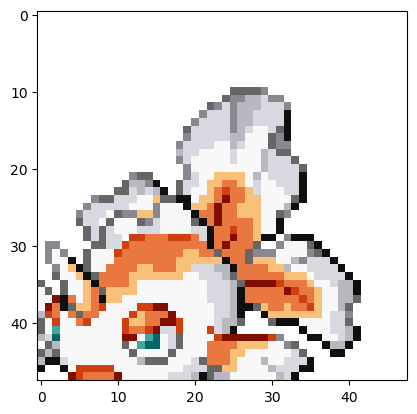

0.03752531:   6%|▌         | 2999/50001 [00:33<08:39, 90.43it/s]

torch.Size([1, 3, 48, 48])


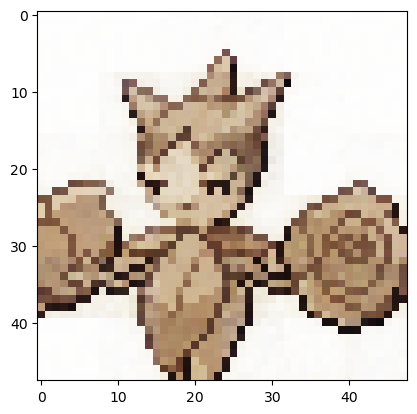

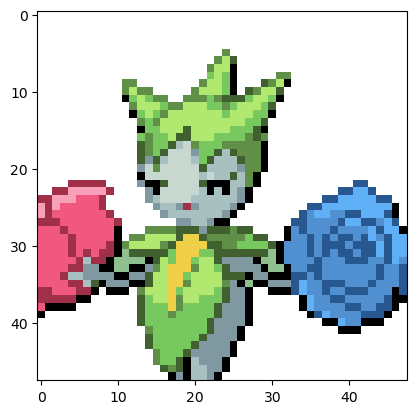

0.04341688:   8%|▊         | 3993/50001 [00:45<08:32, 89.69it/s]

torch.Size([1, 3, 48, 48])


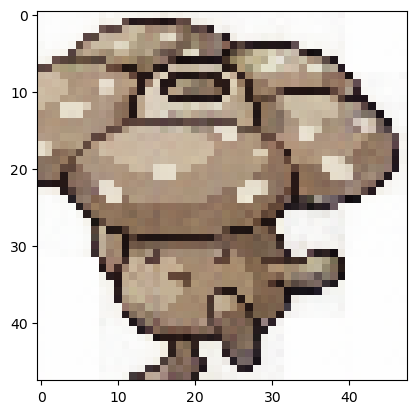

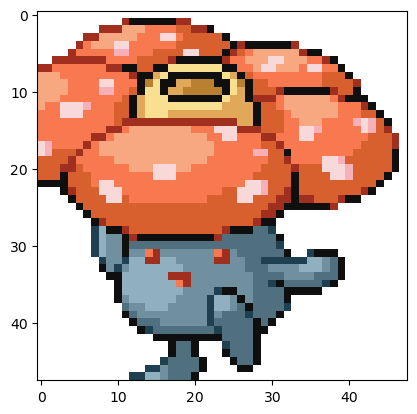

0.05119040:  10%|▉         | 4997/50001 [00:57<09:12, 81.46it/s]

torch.Size([1, 3, 48, 48])


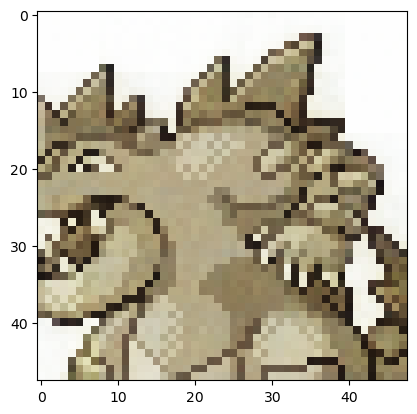

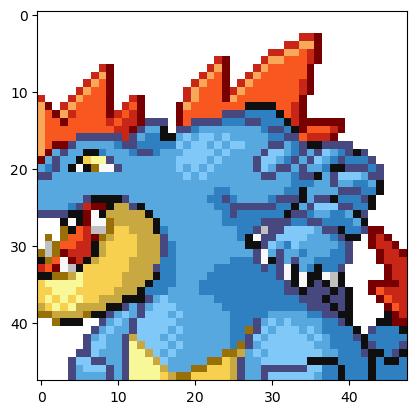

0.04628141:  12%|█▏        | 5998/50001 [01:10<08:08, 90.13it/s]

torch.Size([1, 3, 48, 48])


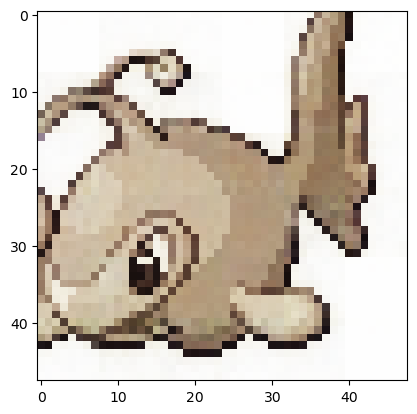

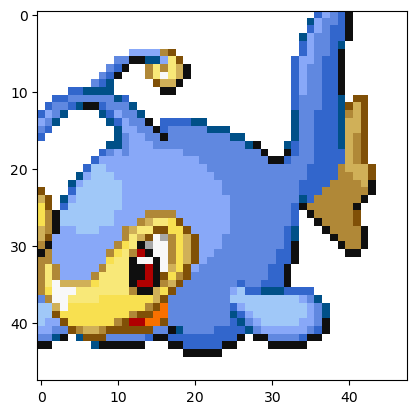

0.04723637:  14%|█▍        | 6999/50001 [01:21<07:58, 89.88it/s]

torch.Size([1, 3, 48, 48])


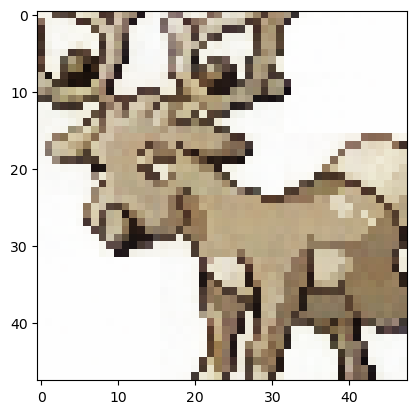

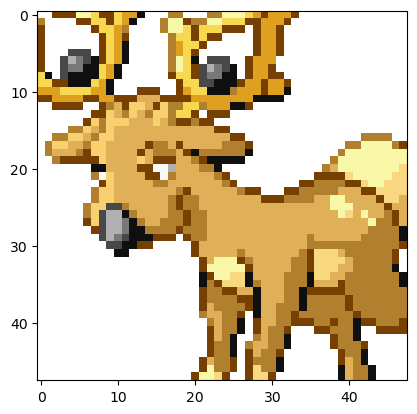

0.04341038:  16%|█▌        | 7991/50001 [01:32<07:49, 89.57it/s]

torch.Size([1, 3, 48, 48])


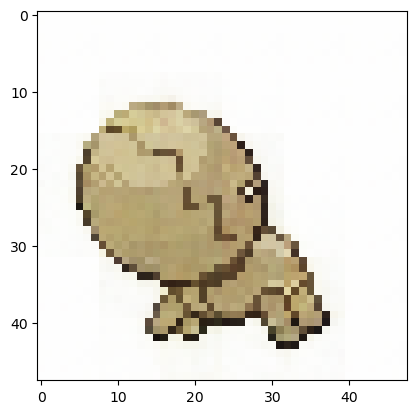

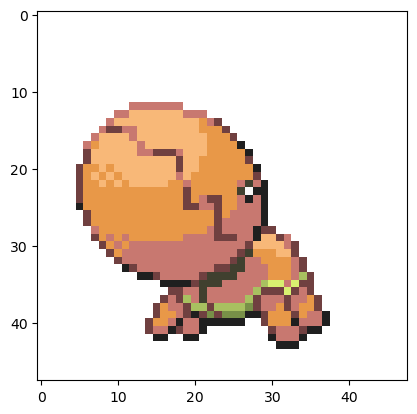

0.05898312:  18%|█▊        | 8992/50001 [01:44<07:39, 89.26it/s]

torch.Size([1, 3, 48, 48])


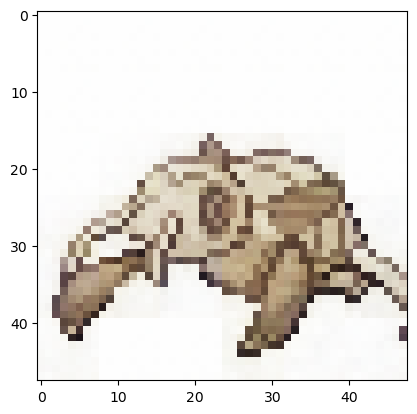

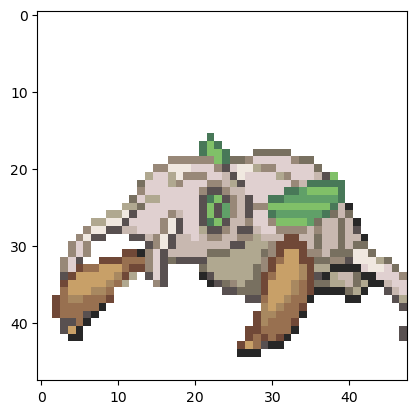

0.04014499:  19%|█▉        | 9432/50001 [01:49<07:49, 86.37it/s]


KeyboardInterrupt: 

In [5]:
bs = 8

model = Colorizer().to(device)

loss_func = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# random crop
Crop = transforms.RandomCrop((48, 48))

pbar = tqdm(range(50001), miniters=1)
def closure():
    optimizer.zero_grad()
    
    # Sample a batch of images
    source = randint(0, 2)
    batch = torch.randperm(385)[:bs]
    x0 = pimages[source, batch]

    x0 = Crop(x0)

    # x.shape = [bs, 3, 64, 64]
    x0 = x0.permute(0, 2, 3, 1)
    x0 = x0.unfold(1, 8, 8).unfold(2, 8, 8).flatten(1, 2) #[bs, 64, 1, 8, 8]
    # x.shape = [bs, 64, 3, 8, 8]

    x0_bw = x0.mean(dim=2, keepdim=True)
    image_rgb = model(x0_bw)
    loss = loss_func(image_rgb, x0)
    
    pbar.set_description(f"%.8f" % loss, refresh=False)

    loss.backward()
    return loss

from torch.nn import functional as F
 
model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 1000 == 0:
        with torch.no_grad():
            model.eval()
            
            source = randint(0, 2)
            batch = torch.randperm(385)[:1]
            x0 = pimages[source, batch]

            x0 = Crop(x0)

            x1 = x0.permute(0, 2, 3, 1)
            x1 = x1.unfold(1, 8, 8).unfold(2, 8, 8).flatten(1, 2) #[bs, 64, 1, 8, 8]
            
            x1_bw = x1.mean(dim=2, keepdim=True)

            # shape = [bs, 64, 1, 8, 8]
            image_rgb = model(x1_bw)
            # shape = [bs, 64, 3, 8, 8]

            # fold image_rgb to [bs, 3, 64, 64]
            image_rgb = image_rgb.permute(0, 2, 3, 4, 1) # [bs, 3, 8, 8, 64]
            image_rgb = image_rgb.flatten(1, 3) # [bs, 192, 64]
            image_rgb = nn.functional.fold(image_rgb, kernel_size=8, output_size=48, stride=8)
            
            print(image_rgb.shape)

            patch = torch.randperm(64)[0]
            plot_image(image_rgb[0])
            plot_image(x0[0])

            model.train()